In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os


In [ ]:
################ regulated pathogen lists ################

In [46]:
# read in pathogen lists from IGSC
aust_rpd = pd.read_excel("/Users/wheelern/Documents/IGSC_seqs/20160919_TaxID.xlsx", sheet_name=0)
eu_rpd = pd.read_excel("/Users/wheelern/Documents/IGSC_seqs/20160919_TaxID.xlsx", sheet_name=1)
cdc_rpd = pd.read_excel("/Users/wheelern/Documents/IGSC_seqs/20160919_TaxID.xlsx", sheet_name=2)
usccl_rpd = pd.read_excel("/Users/wheelern/Documents/IGSC_seqs/20160919_TaxID.xlsx", sheet_name=3)

# drop unwanted rows
def drop_unwanted(df):
    df = df.drop(df[df.Group == 'Bacteria (Toxin)'].index)
    df = df.drop(df[df.Group == 'Metazoa (Toxin)'].index)
    return df

aust_rpd = drop_unwanted(aust_rpd)
eu_rpd = drop_unwanted(eu_rpd)
cdc_rpd = drop_unwanted(cdc_rpd)
usccl_rpd = drop_unwanted(usccl_rpd)

# create lists of regulated taxon ids and common names
reg_taxids = set(aust_rpd.TaxID.values.tolist() + eu_rpd.TaxID.values.tolist() + cdc_rpd.TaxID.values.tolist() + usccl_rpd.TaxID.values.tolist())
pd.DataFrame(reg_taxids).to_csv('databases/biorisk/reg_taxids', index=False)
reg_names = set(aust_rpd.Organism.values.tolist() + eu_rpd.Organism.values.tolist() + cdc_rpd.Organism.values.tolist() + usccl_rpd.Organism.values.tolist())
pd.DataFrame(reg_names).to_csv('databases/biorisk/reg_names', index=False)


In [131]:
# read in regulated organisms
import gspread
from oauth2client.service_account import ServiceAccountCredentials
import taxoniq # this is a new package which looks good, but has some issues with missing taxon IDs

# use creds to create a client to interact with the Google Drive API
scope = ['https://spreadsheets.google.com/feeds', 'https://www.googleapis.com/auth/drive']
creds = ServiceAccountCredentials.from_json_keyfile_name('../client-secret.json', scope)
client = gspread.authorize(creds)

reg_names_ours = []

# read in bacteria
sheet = client.open("Pathogen lists").worksheet("Bacteria")
bact_list = sheet.col_values(1)
australia = sheet.col_values(4)
us_select = sheet.col_values(5)
eu_export = sheet.col_values(7)
russia = sheet.col_values(8)
nih_level = sheet.col_values(6)

# add taxon ids to regulated list
for i in range(1,len(bact_list)):
    if ('Y' in [australia[i], us_select[i], eu_export[i], russia[i]]):
        reg_names_ours.append(bact_list[i])

# read in viruses
sheet = client.open("Pathogen lists").worksheet("Viruses")
virus_list = sheet.col_values(1)
australia = sheet.col_values(4)
us_select = sheet.col_values(5)
eu_export = sheet.col_values(7)
russia = sheet.col_values(8)
nih_level = sheet.col_values(6)

# add taxon ids to regulated list
for i in range(1,len(virus_list)):
    if ('Y' in [australia[i], us_select[i], eu_export[i], russia[i]]):
        reg_names_ours.append(virus_list[i])

# reg_names_ours

<AxesSubplot:>

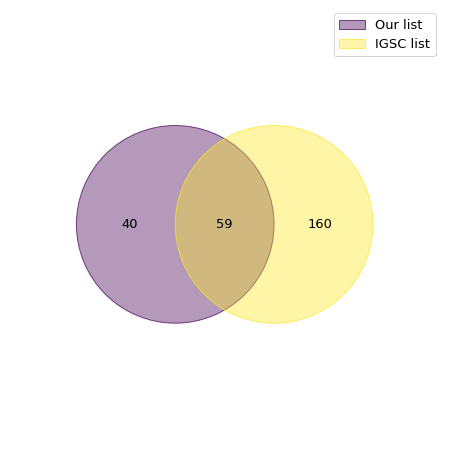

In [134]:
from venn import venn
%matplotlib inline

lists = {
    "Our list": set(reg_names_ours),
    "IGSC list": set(reg_names)
}
venn(lists)

In [132]:
# check for overlap between our and IGSC's databases

reg_names
reg_names_ours

intersection_set = set.intersection(set(reg_names), set(reg_names_ours))
difference_set = set(reg_names).symmetric_difference(set(reg_names_ours))

intersection_list = list(intersection_set)

print(difference_set)

59
219
101
219
{'H5N8 subtype', 'Influenza A virus (A/Iowa/1/1918(H1N1))', 'Laguna Negra virus', 'Escherichia coli O121', 'Xanthomonas citri group', 'Yellow fever virus', 'Venezuelan equine encephalitis virus', 'H5N2 subtype', 'Dengue virus 2', 'Suid herpesvirus 1', 'Plenodomus tracheiphilus', 'Suid alphaherpesvirus 1', 'Xanthomonas oryzae', 'Escherichia coli O157:H16', 'VEEV complex', 'Escherichia coli O157:H39', 'Crimean-Congo hemorrhagic fever virus', 'Russian Spring-Summer encephalitis virus', 'Escherichia coli O121:H46', 'pseudomallei group', 'Escherichia coli O26:H11:K60', 'Colletotrichum kahawae', 'Saint Louis encephalitis virus', 'Xanthomonas alfalfae subsp. citrumelonis', 'Argentinian mammarenavirus', 'Ebola virus', 'H7N7 subtype', 'Vesicular stomatitis New Jersey virus', 'Bipolaris oryzae', 'Seoul orthohantavirus', 'H7N1 subtype', 'Escherichia coli O45:H2', 'Escherichia coli O111:B4', 'Influenza A virus (A/New York/2/1918(H1N1))', 'Rinderpest virus', 'St. Louis encephalitis v

In [133]:
for i in set(reg_names_ours):
    if i not in reg_names:
        print(i) 

Yellow fever virus
Venezuelan equine encephalitis virus
Dengue virus 4
Dengue virus 2
Suid alphaherpesvirus 1
Hantaan orthohantavirus
Bartonella
Crimean-Congo hemorrhagic fever orthonairovirus
Bacillus cereus biovar anthracis
Saint Louis encephalitis virus
Argentinian mammarenavirus
Flexal mammarenavirus
Ebola virus
Seoul orthohantavirus
Rinderpest morbillivirus
Duvenhage lyssavirus
Dobrava-Belgrade orthohantavirus
Teschovirus A
Brazilian mammarenavirus
Peste des petits ruminants virus
Dengue virus 3
Rabies lyssavirus
Nipah henipavirus
Xanthomonas citri
Kyasanur Forest disease virus
Rickettsia rickettsii
Tick-borne encephalitis virus (STRAIN SOFJIN)
Japanese encephalitis virus
Western equine encephalitis virus
Middle East respiratory syndrome-related coronavirus
Dengue virus 1
Avian orthoavulavirus 1
Laguna Negra orthohantavirus
Tick-borne encephalitis virus
Sin Nombre orthohantavirus
Andes orthohantavirus
Mycoplasma mycoides subsp. mycoides
Hendra henipavirus
Eastern equine encephalit